In [1]:
import logging
from typing import List, Callable, Optional, Any

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.decomposition import PCA

from randnn import ContinuousNN, get_attractor_dimension, scaling_analysis, downsample, downsample_split, avg_over
from randnn.utils import np_cache, eigsort, count_cycles
from randnn.plotting import *
from randnn.systems import DoubleWell
from randnn.transfer_operator import *

rc('text', usetex=True)
#logging.basicConfig(level=logging.INFO)

# Applying the transfer operator approach

#### 1. Measurement / Simulation

We begin by simulating the data, a $N$-dimensional time series of $T$ timesteps.

$T \times N$

#### 2. Initial dimensional reduction

In the case of the random neural network, we know that the chaotic dynamics exist near a much lower-dimensional manifold. Therefore, we don't need to deal with a very high-dimensional space (and thus computationally intractable), but can play with a much lower dimensional space.

Using PCA we project down to a dimensionality $D$. We can choose this ourselves, or choose it automatically via some measure of manifold dimensionality. For example, the Lyapunov-spectrum-derived attractor dimension.

Note: this choice of $D$ may not be optimal (Engelken et al. 2020 found that the "PCA dimension" could vary independently from the attractor dimension).

$T \times D$

#### 3. Downsampling 

We are interested in the long-term behavior of the system (and have finitely powerful computers), so we downsample the trajectory with a downsampling rate $D$ (i.e. keeping one in $D$ timesteps).

To determine the optimal number of delays, we choose the number of delays for which the KS entropy stops decresaing.

$T/R \times D$

#### 4. (Optional) Delay embedding

To increase the Markovianity of our state, we may stack delayed copies of measurements within a short time window.

$T/R - K + 1 \times KD$


#### 5. Second dimensionality reduction

From the delay-embedded space, we can project down to a more manageable $M$ dimensions.

$T/R - K + 1 \times M$


#### Transfer Matrix

From any time-series $t \times d$, we can readily compute a transfer matrix.

First, we cluster the time series into $C$ clusters (using, e.g. K-means clustering). This turns our time series into a $t$ dimensional vector, where each entry is the index of that timestep's assigned cluster.

Then, we create a transfer matrix from this series, for a given choice of the transition time scale, $\tau$. 
We create a $C\times C$ dimensional matrix whose $ij$-th component is the likelihood of moving from cluster $i$ to cluster $j$ in $\tau$ timesteps. 

Note: the downsampling rate and transfer matrix transition time scale have roughly the same function. It is, however, computationally easier to downsample as much as possible first.


# Parameters

In [2]:
# ------------------------
# NETWORK PARAMETERS
# ------------------------

# To ensure we compare similar networks:
NETWORK_SEED = 123

# Main parameters:
COUPLING_STRENGTH = 1.8 # Chosen to be just above the chaotic transition (allowing for finite-size effects)
N_NEURONS = 100 # Chosen to be low enough to be easy to work with, yet high enough for a clean Lyapunov spectrum

# The following parameters influence temporal resolution and trajectory duration
TIMESTEP = 0.01 # Short enough that the lyapunov spectrum is still clean
N_STEPS = 50000
N_BURNIN_STEPS = 500

# ------------------------
# COARSE-GRAINING IN SPACE
# ------------------------

# We can either set the explicit choice of pca dimension or determine it from the lyapunov spectrum
PCA_DIMENSION = 20 # "lyapunov" #  int | "lyapunov"

# Explicitly coarse-graining the phase space by clustering (should be << # of downsampled timesteps)
N_CLUSTERS = 100 # This is balanced against the transition timescale. If one is higher, the other can be lower.

# -----------------------
# COARSE-GRAINING IN TIME 
# ------------------------

# Increasing downsampling and state_duration have about the same effect: 
# it increases the length of the time-scales we are interested in
DOWNSAMPLE_RATE = 500
TRANSITION_TIMESCALE = 1

# -----------------------
# STATE-SPACE RECONSTRUCTION
# ------------------------
 
# N delays tells me how many times to stack states into my definition of state.
N_DELAYS = 0

# Embedding dimension is the downprojected space after doing a delay embedding
EMBEDDING_DIM = 3

# -----------------------
# PLOTTING PARAMETERS
# ------------------------

EIGENVALUE_RANGE = [1, 10]

## Understanding finite size effects

For finite-size networks, the transition to chaos is spread. Instead of the network becoming spontaneously chaotic as you increase the coupling strength through the transition, it goes through a number of stages:
1. First, the trivial zero-activity fixed point splits into non-zero fixed points.
2. Next, the non-zero fixed points becoming oscillatory cycles.
3. Finally, the cycles becoming chaotic. Exactly how is not yet clear.

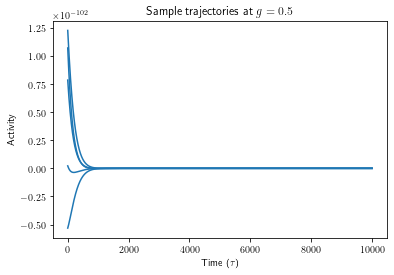

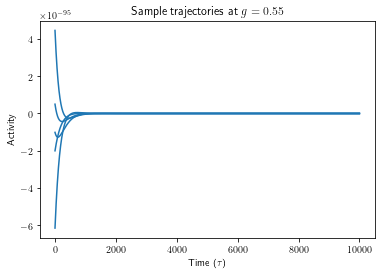

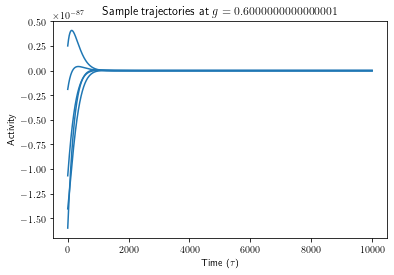

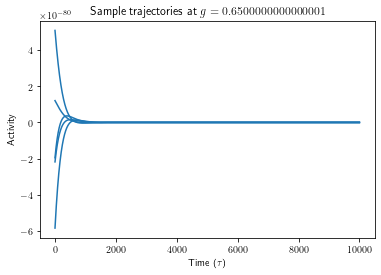

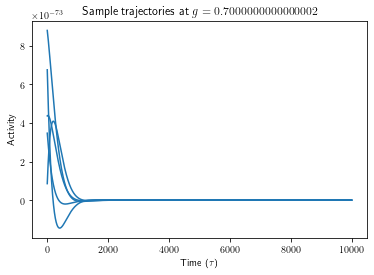

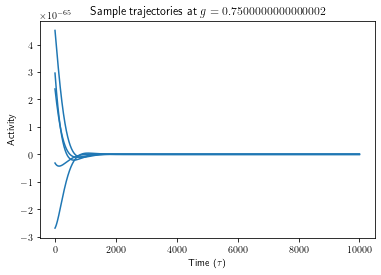

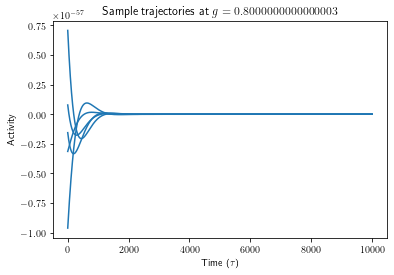

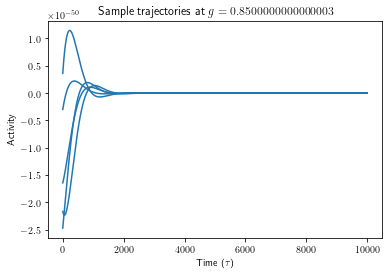

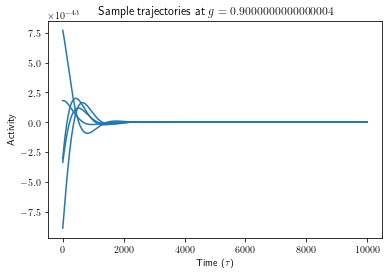

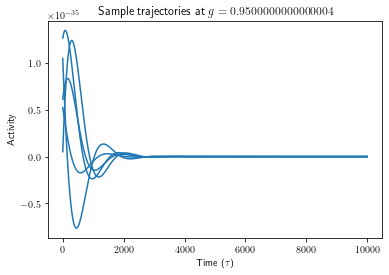

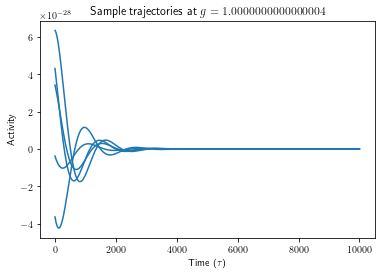

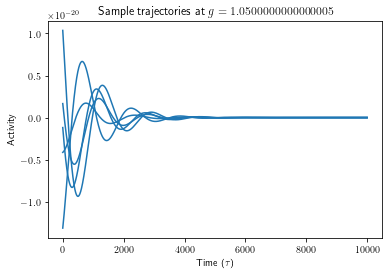

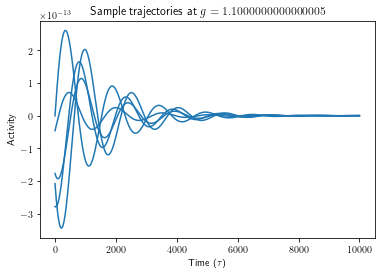

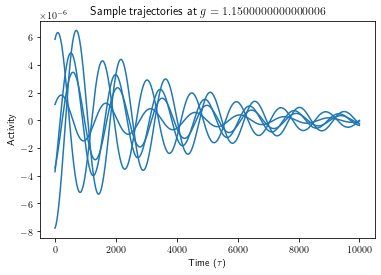

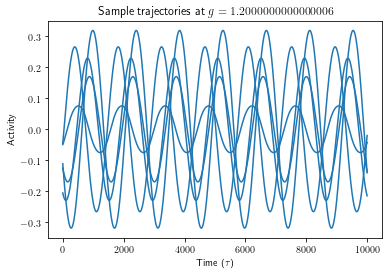

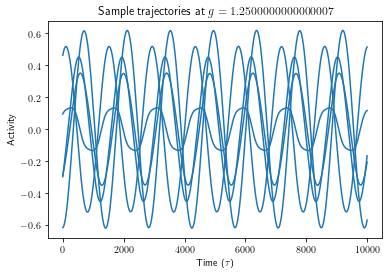

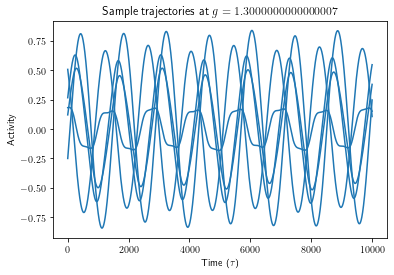

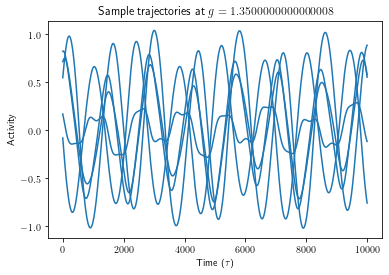

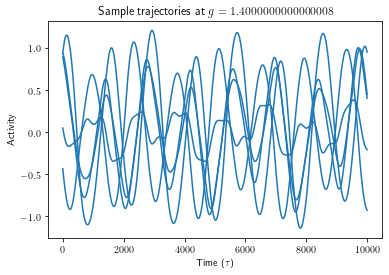

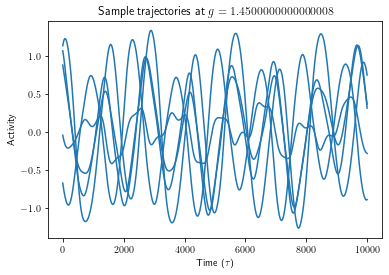

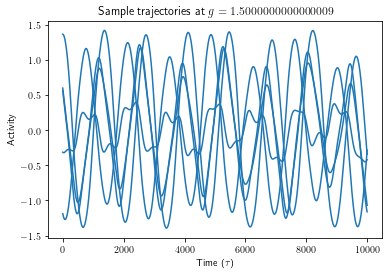

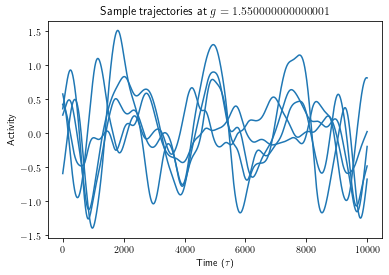

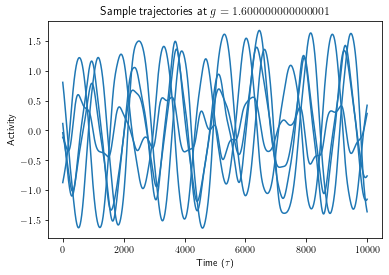

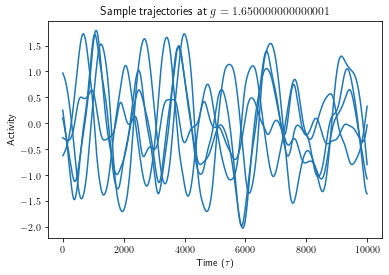

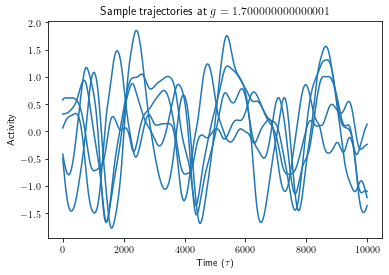

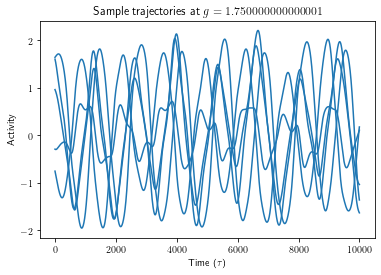

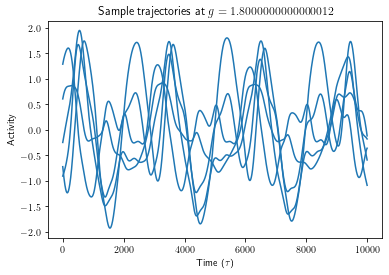

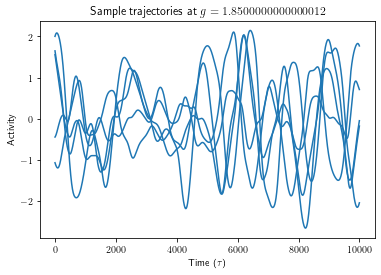

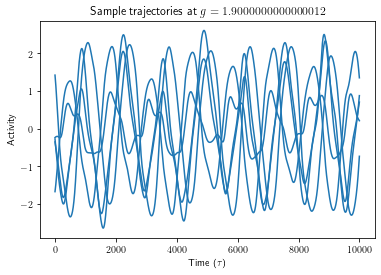

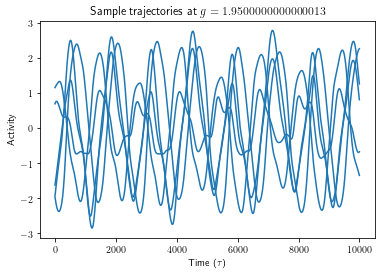

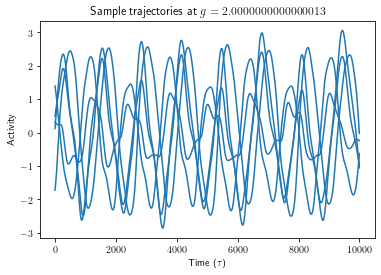

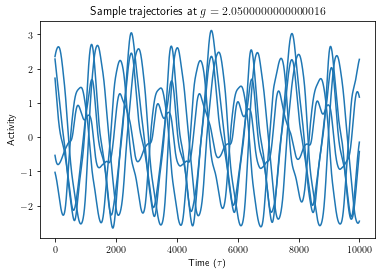

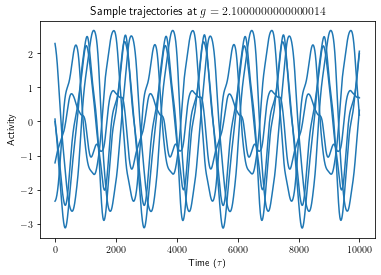

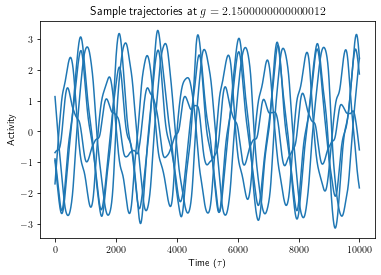

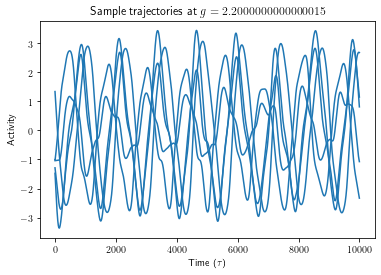

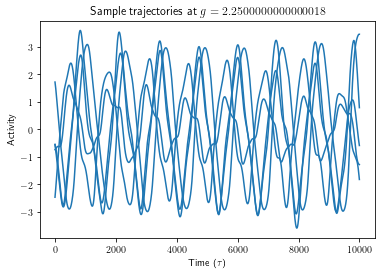

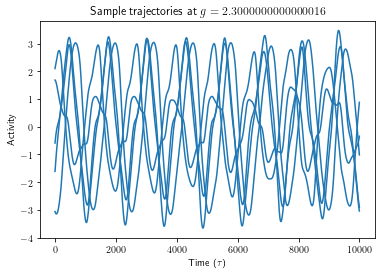

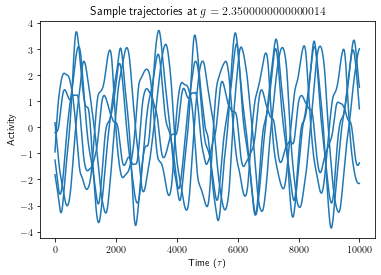

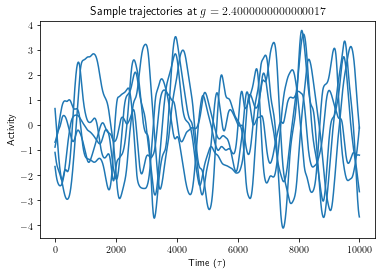

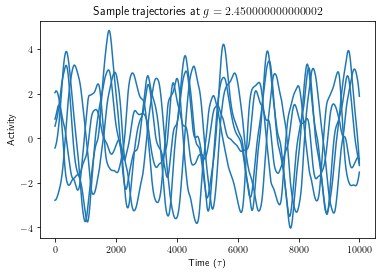

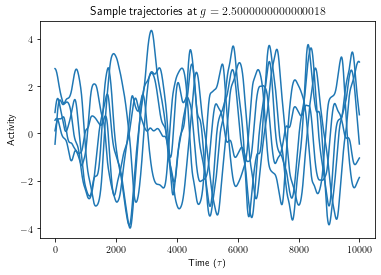

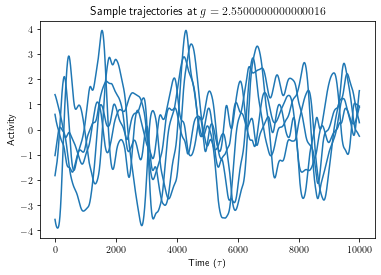

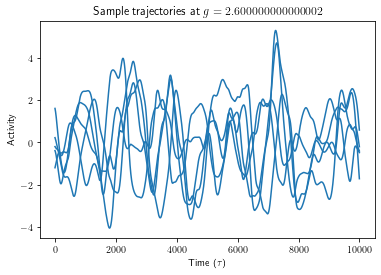

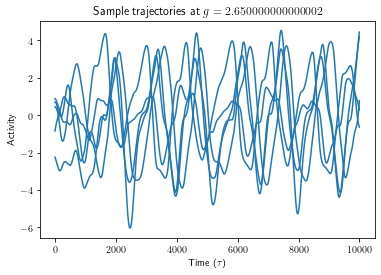

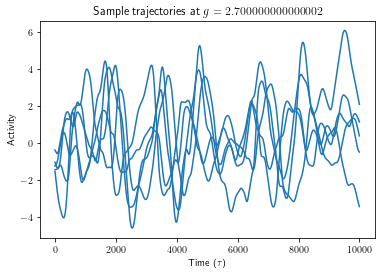

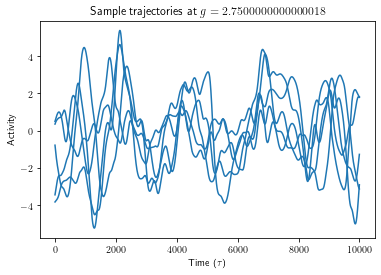

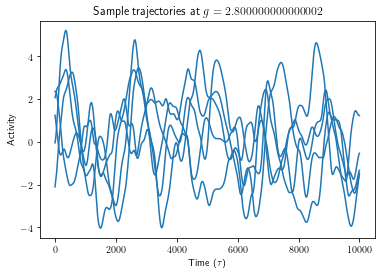

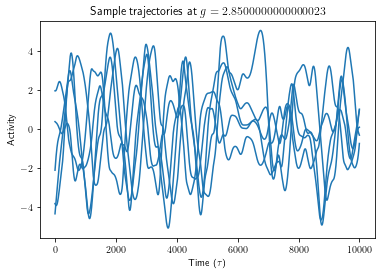

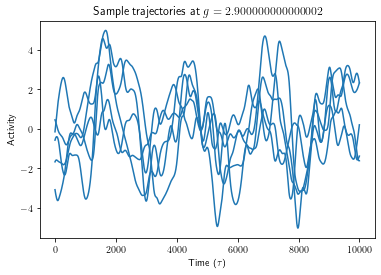

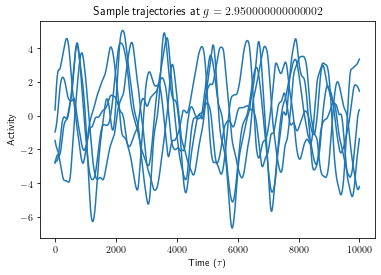

In [3]:
COUPLING_STRENGTHS = np.arange(0.5, 3.0, 0.05)
#COUPLING_STRENGTHS = [0.5, 0.8, 0.9, 1.0, 1.1, 1.2, 1.5, 2.0, 3.0]

for coupling_strength in COUPLING_STRENGTHS[::1]:
    plot_samples(coupling_strength, 
                 n_steps=N_STEPS, 
                 n_burn_in=N_BURNIN_STEPS, 
                 timestep=TIMESTEP,
                 n_dofs=N_NEURONS, 
                 n_sample_steps=10000, 
                 network_seed=NETWORK_SEED)
    plt.show()




### Maximum Lyapunov exponent scaling with coupling strength
The first way to parse this transition is to look at the value of the maximum lyapunov exponent as you increase the coupling strength (for a fixed network size).

KeyboardInterrupt: 

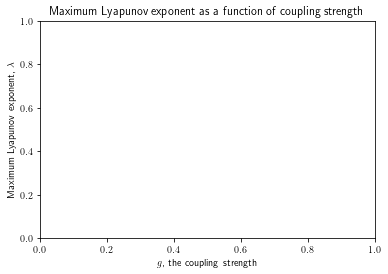

In [4]:
plot_max_l_with_g(gs=COUPLING_STRENGTHS, n_dofs = N_NEURONS, timestep=TIMESTEP, n_steps=N_STEPS, n_burn_in=N_BURNIN_STEPS, network_seed=NETWORK_SEED)

### Dynamic phase diagram

Though the above makes it clear where chaos really begins (up from where it would be in the infinite-network limit), it does not tell us anything about the intermediate phases (i.e. non-zero fixed points and limit cycles).
    
#### Fixed point at zero. 

The first additional sign we can get is by considering what fraction of the neurons settle to the fixed point, where we consider a neuron to be at the trivial fixed point if all the points in a given neuron's history (after a suitable burn-in) are within a desired tolerance of zero.

In [ ]:
ATOL = 1e-1

plot_trivial_fixed_pt_with_g(gs=COUPLING_STRENGTHS, n_dofs = N_NEURONS, timestep=TIMESTEP, n_steps=N_STEPS, n_burn_in=N_BURNIN_STEPS, atol=ATOL, network_seed=NETWORK_SEED)

#### Non-trivial fixed points

The next thing we can do is to study the fraction of neurons that settle to a non-zero fixed point, by the same criterion of "settling" as used for the trivial point.

In [ ]:
plot_nontrivial_fixed_pt_with_g(gs=COUPLING_STRENGTHS, n_dofs = N_NEURONS, timestep=TIMESTEP, n_steps=N_STEPS, n_burn_in=N_BURNIN_STEPS, atol=ATOL, network_seed=NETWORK_SEED)

### Cycles

It starts to get harder when you go looking for cycles. An obvious first-order approach to uncovering cycles is to look for places where the autocorrelation goes through $1$. If such points exist, then the activity is cyclical with the corresponding timescale as its period.

In [ ]:
#CYCLES_COUPLING_STRENGTHS = [1.5, 1.6, 1.65, 1.7, 1.75, 1.8, 1.9, 2.0]
MAX_N_STEPS = 50000
ATOL = 0.1

plot_cycles_with_g(gs=COUPLING_STRENGTHS, n_dofs = N_NEURONS, timestep=TIMESTEP, n_steps=N_STEPS, n_burn_in=N_BURNIN_STEPS, atol=ATOL, max_n_steps=MAX_N_STEPS, network_seed=NETWORK_SEED)

### Autocorrelation timescale

In addition to looking at the number of cycling neurons, we can look at the periods of oscillation, averaged over all cyclical neurons.

I have not yet implemented this, but it might show an interesting trend (and reveal whether chaos unfolds through something like a period doubling catastrophe).

In [ ]:
# TODO: plot_autocorrelation_time_with_g()

## Participation Ratio

Given a covariance matrix, $C_{ij}=\langle (h_i-\langle h_i\rangle)(h_j-\langle h_j\rangle)\rangle$, the participation ratio provides an (PCA) estimate of the dimensionality:
$$
D_\text{PCA}= \frac{(\sum_{n=1}^N \mu_n)^2}{\sum_{n=1}^N \mu_n^2},
$$
where $\mu_n$ is the $n$-th eigenvalue of the covariance matrix.



In [ ]:
plot_participation_ratio_with_g(gs=COUPLING_STRENGTHS, n_dofs = N_NEURONS, timestep=TIMESTEP, n_steps=N_STEPS, n_burn_in=N_BURNIN_STEPS)

---

In [ ]:
def plot_randnn_spectrum(coupling_strength=COUPLING_STRENGTH):
    @downsample(DOWNSAMPLE_RATE)
    def get_pca_reduced_trajectory(dimension=PCA_DIMENSION, coupling_strength=coupling_strength, n_dofs=N_NEURONS, n_steps=N_STEPS, n_burn_in=N_BURNIN_STEPS, t_ons=100):
        cont_nn = ContinuousNN(coupling_strength=coupling_strength, n_dofs=n_dofs, max_step=TIMESTEP)
        trajectory = cont_nn.run(n_steps=n_steps, n_burn_in=n_burn_in)
        lyapunov_spectrum = cont_nn.get_lyapunov_spectrum(trajectory, t_ons=t_ons)

        if dimension == "lyapunov":
            dimension = int(np.ceil(get_attractor_dimension(lyapunov_spectrum)))

        pca = PCA(dimension)
        return pca.fit_transform(trajectory)

    trajectory = get_pca_reduced_trajectory()
    transfer_operator = TransferOperator(labeling_method="kmeans", n_delays=N_DELAYS, embedding_dim=EMBEDDING_DIM)

    def get_trans_matrix(time_series=None, n_clusters=N_CLUSTERS, n_future_timesteps=TRANSITION_TIMESCALE):
        return transfer_operator.get_trans_matrix(time_series=time_series, n_clusters=n_clusters, n_future_timesteps=n_future_timesteps)

    trans_matrix = get_trans_matrix(time_series=trajectory)
    spectrum, _ = eigsort(trans_matrix.T, 100, which='LR')

    plot_eig_spectrum(spectrum, EIGENVALUE_RANGE, "Eigenvalue spectrum of the transfer matrix.", label="Coupling strength, $g = {}$".format(coupling_strength))
    
plot_randnn_spectrum()


In [ ]:
def plot_randnn_spectra(gs=[.9, 1., 1.1, 1.5, 2., 3, 5]):
    plt.title("Eigenvalue spectra for different $g$")
    for g in gs:
        plot_randnn_spectrum(g)

    plt.legend()
    plt.show()
    
plot_randnn_spectra()

In [ ]:

def plot_t_imp_scaling(time_series, eigval_idx, n_clusters_list=[50, 100, 200, 500, 1000], transition_timescales=range(1, 20, 2), timestep=1):
    plt.title("Scaling of $t$ with $\\tau$ and $n_p$")
    for n_clusters in n_clusters_list:
        t_imps = np.zeros(len(transition_timescales))
        for i, tau in tqdm(enumerate(transition_timescales), desc="computing t_imp"):
            t_imps[i] = transfer_operator.get_t_imp(time_series, [eigval_idx], n_clusters, tau, timestep)[0]
            
        plt.plot(transition_timescales, t_imps, label="$n_p = {}$".format(n_clusters))

    plt.legend()
    plt.show()
    
plot_t_imp_scaling(trajectory[:100000:10], 1)
    

![Scaling](./photos/randnn-t-imp-scaling.png)

In [ ]:
def plot_t_imps(time_series, eigval_idxs=range(1,3), n_clusters=N_CLUSTERS, transition_timescales=range(1, 10, 2), timestep=1):
    plt.title("Scaling of $t$ with $\\tau$ and $n_p$")
    t_imps = np.zeros((len(transition_timescales), len(eigval_idxs)))

    for i, tau in tqdm(enumerate(transition_timescales), desc="computing t_imp"):
        t_imps[i, :] = transfer_operator.get_t_imp(time_series, eigval_idxs, n_clusters, tau, timestep)
    
    for i in eigval_idxs:
        plt.plot(transition_timescales, t_imps[:, i])

    plt.show()
    
plot_t_imps(trajectory)

In [ ]:
def plot_trajectory_samples(trajectory: np.ndarray,
                            indices: Union[int, np.ndarray] = 5,
                            title: str = "Sample trajectories"):
    """
    :param trajectory: of shape (n_timesteps, n_dofs)
    :param indices: if int, plots the trajectories of the first `indices` many neurons on top of eachother.
        if np.ndarray, plots the trajectories of the neurons corresponding to the indices in the array.
    """

    try:
        # indices is np.ndarray
        for i in range(indices.size):
            plt.plot(trajectory[:, indices[i]], color="tab:blue")
    except AttributeError:
        # indices is int
        for i in range(indices):
            plt.plot(trajectory[:, i], color="tab:blue")

    plt.title(title)
    plt.xlabel("Time ($\tau$)")
    plt.ylabel("Activity")

def plot_samples(
    coupling_strength: float,
    number: int = 5,
    n_dofs: int = 100,
    timestep: float = 0.1,
    n_steps: int = 10000,
    n_burn_in: int = 1000,
    t_ons: int = 10,
):
    cont_nn = ContinuousNN(coupling_strength=coupling_strength,
                           n_dofs=n_dofs,
                           max_step=timestep)
    trajectory = cont_nn.run(n_steps=n_steps, n_burn_in=n_burn_in)

    plot_trajectory_samples(
        trajectory,
        number,
        title="Sample trajectories at $g={}$".format(coupling_strength))

